In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.mlab as mlab
import math
import seaborn as sns
import numpy as np
import sklearn.mixture
import pymc3 as pm
import theano
import pandas as pd
sns.set()

/home/oscarmartinez/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [34]:
matches_csv=pd.read_csv('premier_league_17-18.csv')
matches_upcoming_csv=pd.read_csv('upcoming_matches_17-18.csv')

In [33]:
def get_teams(matches):
    teams=matches.HomeTeam.unique()
    teams=pd.DataFrame(teams,columns=['team'])
    teams['i']=teams.index
    return teams

def get_matches(matches,teams):
    matches=pd.merge(matches,teams,left_on='HomeTeam',right_on='team',how='left')
    matches=matches.rename(columns={'i':'ihome'}).drop('team',1)
    matches=pd.merge(matches,teams,left_on='AwayTeam',right_on='team',how='left')
    matches=matches.rename(columns={'i':'iaway'}).drop('team',1)
    home_team=matches.ihome.values
    away_team=matches.iaway.values
    
    return matches,home_team,away_team

def goals(matches):
    observed_home_goals=matches.FTHG.values
    observed_away_goals=matches.FTAG.values
    
    return observed_home_goals, observed_away_goals

    

In [35]:
teams=get_teams(matches_csv)
matches,home_team,away_team=get_matches(matches_csv,teams)
observed_home_goals,observed_away_goals=goals(matches)

In [36]:
matches_upcoming,home_team_upcoming,away_team_upcoming=get_matches(matches_upcoming_csv,teams)

In [50]:
matches_upcoming.head(5)

,HomeTeam,AwayTeam,ihome,iaway
0,West Ham,Leicester,0,11
1,Crystal Palace,Stoke,1,19
2,Liverpool,Chelsea,2,16
3,Man United,Brighton,3,10
4,Newcastle,Watford,4,12


In [37]:
observed_home_goals_shared=theano.shared(observed_home_goals)
observed_away_goals_shared=theano.shared(observed_away_goals)
home_team_shared=theano.shared(home_team)
away_team_shared=theano.shared(away_team)

In [38]:
with pm.Model() as model_predict:
    avg=pm.Normal('avg',mu=0,sd=1)
    home_adv=pm.Normal('home_adv',mu=0,sd=1)
    off_hab=pm.Normal('off_hab',mu=0,sd=0.5,shape=len(teams))
    deff_hab=pm.Normal('deff_hab',mu=0,sd=0.5,shape=len(teams))
    
    lambda_home=np.exp(avg+home_adv+off_hab[home_team_shared]-deff_hab[away_team_shared])
    lambda_away=np.exp(avg-home_adv+off_hab[away_team_shared]-deff_hab[home_team_shared])
    
    FTHG=pm.Poisson('FTHG',mu=lambda_home,observed= observed_home_goals_shared)
    FTAG=pm.Poisson('FTAG',mu=lambda_away,observed=observed_away_goals_shared)

In [10]:
n_samples=1000
tune_samples=500

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [deff_hab, off_hab, home_adv, avg]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:10<00:00, 588.68draws/s]


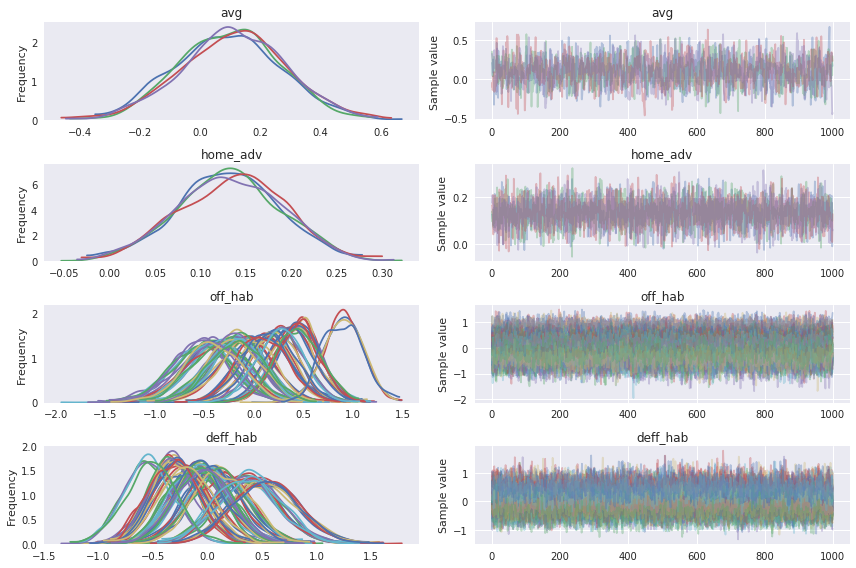

In [39]:
with model_predict:
    trace=pm.sample(draws=n_samples,tune=tune_samples,njobs=4)
    pm.traceplot(trace)

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
avg,0.083674,0.168196,0.004053,-0.254469,0.412478,1667.803968,0.999605
home_adv,0.132646,0.058127,0.000940,0.015284,0.244460,4213.968927,0.999557
off_hab__0,0.377155,0.238821,0.004203,-0.084083,0.849904,3559.058049,0.999844
off_hab__1,-0.139546,0.258271,0.004450,-0.628686,0.389564,3534.446580,0.999787
off_hab__2,0.437690,0.233519,0.004018,-0.010377,0.882724,3841.828884,0.999607
off_hab__3,-0.552345,0.292352,0.004613,-1.133410,-0.008370,3769.314551,1.000627
off_hab__4,-0.064966,0.262248,0.004148,-0.594632,0.421376,4010.268448,0.999894
off_hab__5,-0.406447,0.287875,0.004395,-0.967280,0.154400,4218.869233,1.000076
off_hab__6,0.201951,0.242156,0.003757,-0.300083,0.647424,3518.864477,1.000533
off_hab__7,-0.355332,0.288899,0.004633,-0.906900,0.215711,3781.222712,1.000231


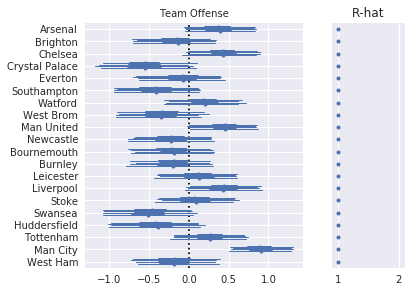

In [40]:
labels=teams.team.values
pm.forestplot(trace,varnames=['off_hab'],ylabels=labels,main='Team Offense')

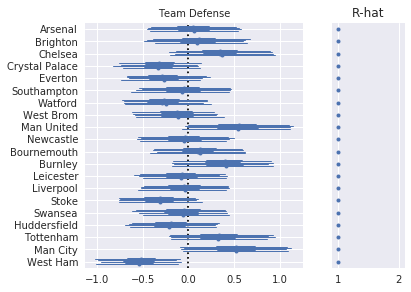

In [41]:
labels=teams.team.values
pm.forestplot(trace,varnames=['deff_hab'],ylabels=labels,main='Team Defense')

In [42]:
home_team_shared.set_value(home_team_upcoming)
away_team_shared.set_value(away_team_upcoming)
observed_home_goals_shared.set_value([0]*len(home_team_upcoming))
observed_away_goals_shared.set_value([0]*len(home_team_upcoming))

In [43]:
n_samples_predict=(n_samples+tune_samples)*4
n_samples_predict

6000

In [44]:
post_pred=pm.sample_ppc(trace,model=model_predict,samples=n_samples_predict)

100%|██████████| 6000/6000 [01:56<00:00, 51.33it/s]


In [45]:
def predict_points(post_pred):
    rows=post_pred['FTHG'].shape[1]
    cols=post_pred['FTHG'].shape[0]
    pred_home_points=np.zeros((rows,cols))
    pred_away_points=np.zeros((rows,cols))
    sim_index=[]
    for i in range(cols):
        home_win=post_pred['FTHG'][i,:]>post_pred['FTAG'][i,:]
        home_win=home_win.astype(int)*3
        home_draw=post_pred['FTHG'][i,:]==post_pred['FTAG'][i,:]
        home_draw=home_draw.astype(int)
        home_points=home_win +home_draw
        pred_home_points[:,i]=home_points
        away_win=post_pred['FTHG'][i,:]<post_pred['FTAG'][i,:]
        away_win=away_win.astype(int)*3
        away_draw=post_pred['FTHG'][i,:]==post_pred['FTAG'][i,:]
        away_draw=away_draw.astype(int)
        away_points=away_win +away_draw
        pred_away_points[:,i]=away_points

        sim_index.append('sim_points_{}'.format(i)) 
        
    df_home_point=pd.DataFrame(data=pred_home_points.astype(int),columns=sim_index)
    df_home_point.insert(0,'team',matches_upcoming['HomeTeam'])

    df_away_point=pd.DataFrame(data=pred_away_points.astype(int),columns=sim_index)
    df_away_point.insert(0,'team',matches_upcoming['AwayTeam'])
    return df_home_point,df_away_point

In [46]:
df_home_point,df_away_point=predict_points(post_pred)


In [29]:
df_home_point

,team,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,sim_points_8,...,sim_points_5990,sim_points_5991,sim_points_5992,sim_points_5993,sim_points_5994,sim_points_5995,sim_points_5996,sim_points_5997,sim_points_5998,sim_points_5999
0,West Ham,1,3,3,3,3,0,1,3,1,...,3,3,1,3,1,3,1,1,3,1
1,Crystal Palace,3,0,3,3,3,3,1,3,3,...,0,3,3,3,3,1,3,0,1,3
2,Liverpool,3,3,3,3,1,3,3,3,3,...,3,3,1,3,3,3,3,3,3,3
3,Man United,0,0,1,1,1,1,3,0,1,...,3,1,1,0,3,0,1,3,0,1
4,Newcastle,1,3,0,0,0,1,3,1,3,...,0,0,3,1,3,1,3,1,3,3
5,Swansea,1,0,3,3,1,1,0,3,1,...,1,1,0,0,1,3,0,1,3,3
6,Tottenham,0,0,3,3,3,0,1,1,1,...,1,0,3,0,3,0,1,3,3,0
7,Burnley,0,3,0,1,3,0,0,1,3,...,0,3,3,3,3,0,3,3,1,0
8,Huddersfield,0,0,0,0,3,0,1,3,1,...,1,0,0,1,3,0,3,3,1,1
9,Southampton,0,0,0,3,3,0,1,0,3,...,3,0,0,0,1,0,1,1,3,3


In [30]:
df_away_point

,team,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,sim_points_8,...,sim_points_5990,sim_points_5991,sim_points_5992,sim_points_5993,sim_points_5994,sim_points_5995,sim_points_5996,sim_points_5997,sim_points_5998,sim_points_5999
0,Leicester,1,0,0,0,0,3,1,0,1,...,0,0,1,0,1,0,1,1,0,1
1,Stoke,0,3,0,0,0,0,1,0,0,...,3,0,0,0,0,1,0,3,1,0
2,Chelsea,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,Brighton,3,3,1,1,1,1,0,3,1,...,0,1,1,3,0,3,1,0,3,1
4,Watford,1,0,3,3,3,1,0,1,0,...,3,3,0,1,0,1,0,1,0,0
5,Bournemouth,1,3,0,0,1,1,3,0,1,...,1,1,3,3,1,0,3,1,0,0
6,West Brom,3,3,0,0,0,3,1,1,1,...,1,3,0,3,0,3,1,0,0,3
7,Arsenal,3,0,3,1,0,3,3,1,0,...,3,0,0,0,0,3,0,0,1,3
8,Man City,3,3,3,3,0,3,1,0,1,...,1,3,3,1,0,3,0,0,1,1
9,Everton,3,3,3,0,0,3,1,3,0,...,0,3,3,3,1,3,1,1,0,0


In [47]:
standings=df_home_point.groupby('team').sum().add(df_away_point.groupby('team').sum())                  


In [48]:
standings

,sim_points_0,sim_points_1,sim_points_2,sim_points_3,sim_points_4,sim_points_5,sim_points_6,sim_points_7,sim_points_8,sim_points_9,...,sim_points_5990,sim_points_5991,sim_points_5992,sim_points_5993,sim_points_5994,sim_points_5995,sim_points_5996,sim_points_5997,sim_points_5998,sim_points_5999
team,,,,,,,,,,,,,,,,,,,,,
Arsenal,52,52,36,40,66,46,49,26,43,48,...,31,43,52,43,46,52,50,48,54,48
Bournemouth,29,32,23,28,27,32,28,35,47,29,...,48,20,32,24,49,37,42,38,36,46
Brighton,47,41,52,25,46,42,38,32,27,43,...,51,30,26,40,44,46,19,24,41,33
Burnley,25,33,43,37,40,28,35,38,22,47,...,46,40,33,44,40,21,34,47,22,27
Chelsea,52,63,49,58,50,52,46,49,56,50,...,62,31,66,48,58,53,60,54,64,49
Crystal Palace,19,33,8,25,13,14,17,17,26,9,...,12,21,30,12,23,19,11,21,13,14
Everton,20,27,37,41,26,30,24,21,29,39,...,25,32,27,26,22,39,32,31,44,26
Huddersfield,24,8,18,21,24,17,32,25,18,35,...,34,32,37,32,19,26,38,19,23,36
Leicester,46,30,26,35,33,47,56,46,55,33,...,39,24,31,51,45,67,36,24,55,34


In [49]:
standing_tot=[]
standing_dict={}
for i in range(n_samples_predict):
    sim=standings['sim_points_{}'.format(i)].sort_values(ascending=False)
    standing_list=sim.index.tolist()
    for i,team in enumerate(standing_list):
        standing_tot.append(str(i+1)+' '+team)
        standing_dict[str(i+1)+' '+team]=standing_tot.count(str(i+1)+' '+team)

In [50]:
standing_dict = {k: v /60 for k, v in standing_dict.items()}

In [51]:
standing_dict

{'1 Man City': 69.15,
 '2 Man United': 24.116666666666667,
 '3 Liverpool': 12.4,
 '4 Chelsea': 16.416666666666668,
 '5 Arsenal': 14.266666666666667,
 '6 Tottenham': 12.133333333333333,
 '7 Watford': 7.833333333333333,
 '8 Brighton': 7.4,
 '9 Leicester': 10.283333333333333,
 '10 Stoke': 8.85,
 '11 Bournemouth': 8.416666666666666,
 '12 Burnley': 7.15,
 '13 Huddersfield': 6.266666666666667,
 '14 Southampton': 8.283333333333333,
 '15 Everton': 7.9,
 '16 West Brom': 10.433333333333334,
 '17 Crystal Palace': 11.183333333333334,
 '18 Swansea': 11.75,
 '19 Newcastle': 5.5,
 '20 West Ham': 23.866666666666667,
 '1 Man United': 12.816666666666666,
 '2 Chelsea': 24.4,
 '3 Man City': 7.316666666666666,
 '4 Tottenham': 14.5,
 '6 Liverpool': 11.333333333333334,
 '7 Brighton': 6.283333333333333,
 '8 Stoke': 6.9,
 '9 Crystal Palace': 0.7666666666666667,
 '10 Burnley': 8.316666666666666,
 '11 Watford': 8.6,
 '12 Bournemouth': 8.15,
 '13 Southampton': 7.066666666666666,
 '14 Newcastle': 8.416666666666666

In [24]:
first_prob=[]
first_team=[]
second_prob=[]
second_team=[]
third_prob=[]
third_team=[]
last_prob=[]
last_team=[]
penultimate_prob=[]
penultimate_team=[]

for k,v in standing_dict.items():
    if k.endswith(' 1'):
        first_team.append(k[:-2])
        first_prob.append(round(v,2))
    elif k.endswith(' 2'):
        second_team.append(k[:-2])
        second_prob.append(round(v,2))
    elif k.endswith(' 3'):
        third_team.append(k[:-2])
        third_prob.append(round(v,2))
    elif k.endswith(' 20'):
        last_team.append(k[:-2])
        last_prob.append(round(v,2))
    elif k.endswith(' 19'):
        penultimate_team.append(k[:-2])
        penultimate_prob.append(round(v,2))

In [53]:
def standings_probs(standing_dict):
    first_prob=[]
    first_team=[]
    second_prob=[]
    second_team=[]
    third_prob=[]
    third_team=[]
    last_prob=[]
    last_team=[]
    penultimate_prob=[]
    penultimate_team=[]

    for k,v in standing_dict.items():
        if k.startswith('1 '):
            first_team.append(k[2:])
            first_prob.append(round(v,2))
        elif k.startswith('2 '):
            second_team.append(k[2:])
            second_prob.append(round(v,2))
        elif k.startswith('3 '):
            third_team.append(k[2:])
            third_prob.append(round(v,2))
        elif k.startswith('20 '):
            last_team.append(k[3:])
            last_prob.append(round(v,2))
        elif k.startswith('19 '):
            penultimate_team.append(k[3:])
            penultimate_prob.append(round(v,2))
    
    return first_team,first_prob,second_team,second_prob,third_team,third_prob,last_team,last_prob,penultimate_team,penultimate_prob


In [54]:
first_team,first_prob,second_team,second_prob,third_team,\
third_prob,last_team,last_prob,penultimate_team,penultimate_prob=standings_probs(standing_dict)

Text(0.5,1,'Probability for teams to finish 1st in the 17-18 season')

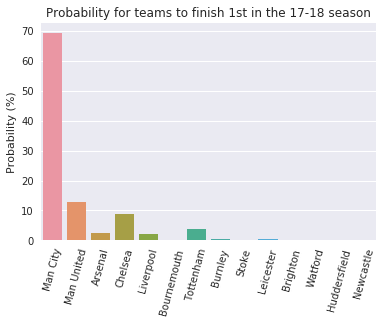

In [55]:
ax = sns.barplot(x=first_team, y=first_prob)
plt.xticks(rotation=75)
plt.ylabel("Probability (%)")
plt.title('Probability for teams to finish 1st in the 17-18 season')

Text(0.5,1,'Probability for teams to finish 2nd in the 17-18 season')

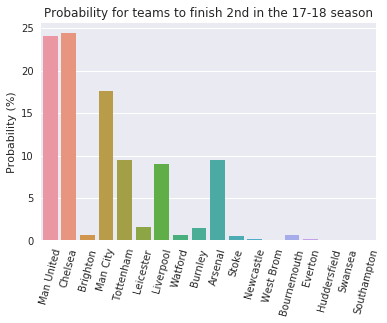

In [56]:
ax = sns.barplot(x=second_team, y=second_prob)
plt.xticks(rotation=75)
plt.ylabel("Probability (%)")
plt.title('Probability for teams to finish 2nd in the 17-18 season')